# Assignment 2 - 4442 - Titanic dataset
Udara Jayawardena • tjayawa@uwo.ca

We'll be using the titanic traning dataset to build a classification model for predicting the survival of passengers from the tests data. 


## Exploring & cleaning the data

In [493]:
import pandas as pd
import matplotlib.pyplot as plt

test = pd.read_csv("./data/test.csv")
test_shape = test.shape
print(test_shape) # rows, cols

(418, 11)


In [494]:
train = pd.read_csv("./data/train.csv")
train_shape = train.shape
print(train_shape) # rows, cols

(891, 12)


As we can see from above the data set contains 891 rows of training data. 

We can do a light analysis to better understand the dataset. From the titanic data-set specifically we need to take into consideration certain things like children and women being evacuated first, favouring their survival. 

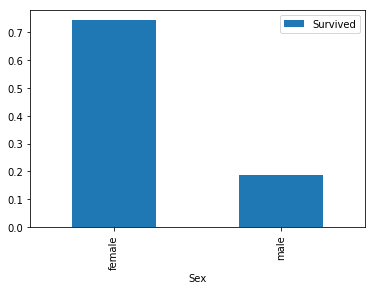

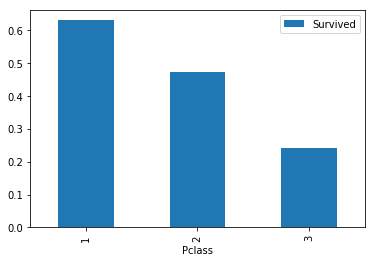

In [495]:
train = pd.read_csv("./data/train.csv")

# using sex as a pivot
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

# using passenger class as a pivot
pclass_pivot = train.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

We can clearly see from above that women survived over 3x more than men, and the higher your class, the higher the chance you'd survive.  

Looking at age as a series: 

In [496]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

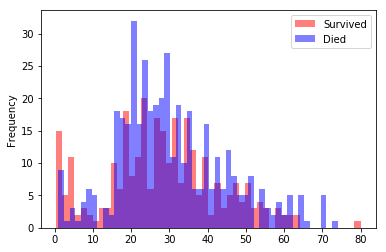

In [497]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

From the above histogram we can gather that some age groups survived more than others. Specifically the ones where the red bars rise above the blue onee; in this case we can see that primarily with children < 5 years old.  

Age is a continuvous feature and inorder to build a model around it we need the data to be more categorical. In this case we can divide the age into ranges to obtain categorical data.

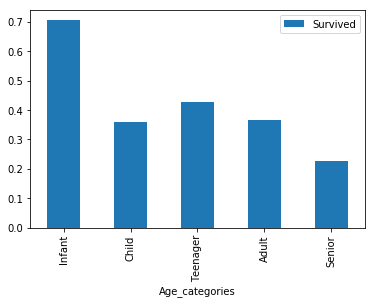

In [498]:
def process_age(df,cut_points,label_names):
    df['Age'] = df['Age'].fillna(df['Age'].median()) 
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [0, 5, 12, 18, 60, 100]
label_names = ['Infant', "Child", 'Teenager', 'Adult', 'Senior']

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

age_cat_pivot = train.pivot_table(index="Age_categories",values="Survived")
age_cat_pivot.plot.bar()
plt.show()

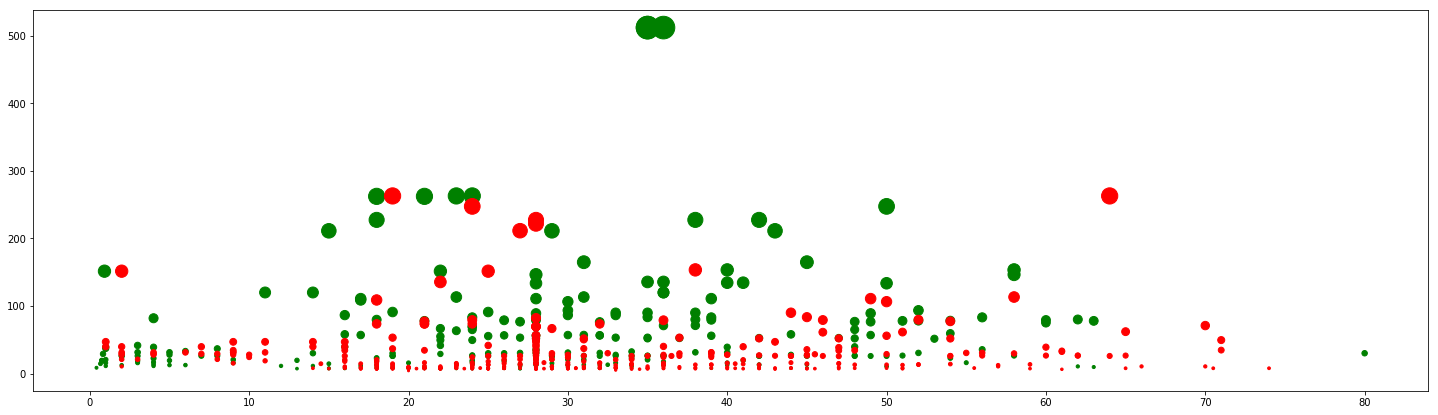

In [499]:
plt.figure(figsize=(25, 7))
ax = plt.subplot()
# Green = survived, Red = died, size of circle is proportional to fare
ax.scatter(train[train['Survived'] == 1]['Age'], train[train['Survived'] == 1]['Fare'], 
           c='green', s=train[train['Survived'] == 1]['Fare'])
ax.scatter(train[train['Survived'] == 0]['Age'], train[train['Survived'] == 0]['Fare'], 
           c='red', s=train[train['Survived'] == 0]['Fare']);

From the above analysis we can see that adults (20-45 age) who payed a higer fare tended to survive more.


### Some feature extraction 

As a part of feature extraction and engineering I decided to pull the titles from the names column. I didn't end up using all of this in the final model beacuase it results in a significant decrease in the accuracy of the model.

In [500]:
titles_dict = {
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
}

def get_titles(data):
    data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    data['Title'] = data.Title.map(titles_dict)
    return data

train = get_titles(train)
test = get_titles(test)

I also extracted a family size variable out of the the parents and sibling data made available to us. The logic here comes from the idea that larger families stary together and are likely to be rescued together vs a single person in a ship. Use of this featrue increased the accuracy of the model by 3%.

In [501]:
def process_family(data):
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
    data['Singleton'] = data['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    data['SmallFamily'] = data['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    data['LargeFamily'] = data['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    return data

train = process_family(train)
test = process_family(test)

We will also extract the cabin deck levels from the data. It provides some useful data to explore as Deck A is on the surface and preceding decks go lower and lower into the ship. We could think that people in the lowest decks would have a harder time escaping and being rescued. 

In [502]:
def process_cabin(data):
    data.Cabin.fillna('U', inplace=True)
    data['Cabin'] = data['Cabin'].map(lambda c: c[0])
    cabin_dummies = pd.get_dummies(data['Cabin'], prefix='Cabin')    
    data = pd.concat([data, cabin_dummies], axis=1)

    data.drop('Cabin', axis=1, inplace=True)
    return data

train = process_cabin(train)
test = process_cabin(test)

In preparation of building our model we need to clean up our data columns so as to prevent any confusion for the model. For example the PClass has a value of [1,2,3] but the numerical value of 1,2 or 3 does not imply anything. So we need to move the classes to columns of their own so we can treat them as binary trails (i.e. the person is in 1st class).

In [503]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

# Create dummy columns for passenger class, sex and age_categories for the both the datasets
train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")
train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")
train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")
train = create_dummies(train,"Embarked")
test = create_dummies(test,"Embarked")
train = create_dummies(train,"Title")
test = create_dummies(test,"Title")

# Naive Bayes model


The basic Naive Bayes model created by running all the traning data through it. However this could lead to over-fitting. 

### Splitting up training data

In [504]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Adult',
       'Age_categories_Senior', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize', 
           'Singleton', 'SmallFamily', 'LargeFamily', 'Title_Mrs', 'Title_Mr',
           'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G']

holdout = test
all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.2, random_state=0)

### Train the model, make predictions and test accuracy

In [505]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

clf = GaussianNB()
clf.fit(train_X, train_y)
predictions = clf.predict(test_X)
accuracy = accuracy_score(test_y, predictions)

conf_matrix = confusion_matrix(test_y, predictions)
pd.DataFrame(conf_matrix, columns=['Survived', 'Died'], index=[['Survived', 'Died']])

,Survived,Died
Survived,94,16
Died,14,55


The above was done with a small subset of the data (20%) hence we might be overfitting the model. We will now use cross validation to train and test our model across different subsets of the data. 

In [506]:
from sklearn.model_selection import cross_val_score
import numpy as np

lr = GaussianNB()
scores = cross_val_score(lr, all_X, all_y, cv=10)
np.mean(scores)

0.7903838951310862

### Train a Naive Bayes model using all the data

In [507]:
clf = GaussianNB()
clf.fit(all_X, all_y)
holdout_predictions = clf.predict(holdout[columns])
# holdout_predictions

# Multi-layer perceptron
For this I've jumped directly to the cross-validation step to test for accuracy. I'm using the Limited-memory BFGS for the weight optimization and I've worked with differetn alpha vales and layer sizes to optomize for the accuracy of the model. 

In [525]:
from sklearn.neural_network import MLPClassifier

pclf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 9), random_state=1)
scores = cross_val_score(pclf, all_X, all_y, cv=10)
np.mean(scores)

0.8317444103960957

From the above analysis we can see that we can obtain a more accuratr model using the supervised netural net approach. Hence I will use that for my final predictions. 

### Improvements made to the data to improve accuracy 

When playing with the data I noticed th inclusion of the fare when training the model lead to less acurate results. Fare can be a confusing metric as there are multiple ports of embarkement. I chose to use just the embarked port and passenger class converted into categorical variables instead of the fare as they would more accurately (and categorically) represent what is implied by the Fare. 

# Final predictions

In [509]:
pclf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 9), random_state=1)
pclf.fit(all_X, all_y)
holdout_predictions = pclf.predict(holdout[columns])

# Create submission
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv('./data/submit.csv', index=False)

# Results 

The final result on Kaggle got a accuracy score of 0.77511 and ranked at #3963.